# Mevsimsel Olmayan Zaman Serisi Tahminleri için Basit ARIMA Modeli

Bu zorluktaki hedefimiz, zaman serisi analizinin temel kavramlarını tek boyutlu verilere uygulamaktır

Bu zorluklarda şu adımları izleyeceğiz:
1. verileri yükleme ve görselleştirme;
2. modellerimizi eğitme ve tahminler yapma;

##  1. Veri Yükleme
Zorlukta kullanacağımız zaman serisini yükleyerek başlayalım. Veri setini CSV dosyası olarak indirmek için aşağıdaki satırı çalıştırın, ardından CSV'yi bir DataFrame'e yükleyin.

In [1]:
!curl https://d32aokrjazspmn.cloudfront.net/materials/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0    763      0 --:--:-- --:--:-- --:--:--   764


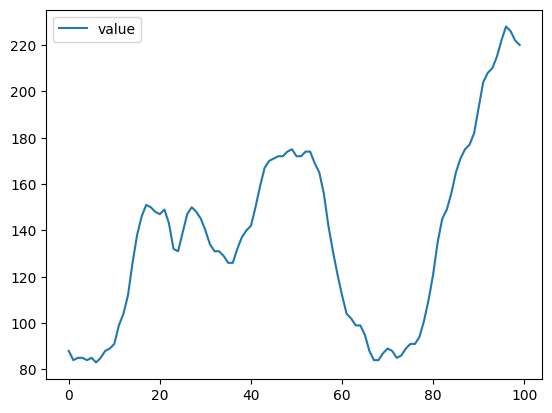

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();

Bu soyut zaman serisi mevsimsel görünmüyor, ancak artan bir trend ve bir şekilde "yapışkan" (yani biraz oto-regresif) özellikler gösteriyor. Bu nedenle Oto-Regresif Hareketli Ortalama (ARIMA) modelleri için iyi bir aday olabilir.

## 2. ARIMA Modeli Oluşturma
ARIMA modelleri (Oto Regresif Entegre Hareketli Ortalama) sayesinde verileri tahmin etmeye çalışacağız.

Bunun için şunları yapmamız gerekecek:
1. zaman serisini nasıl durağanlaştırılacağını bulma (ARIMA'daki I)
2. oto-regresif (AR) kısmını bulma
3. hareketli ortalama (MA) kısmını bulma
4. Uydurma
5. Performansı değerlendirme

### Adım 1 - Durağanlığı Sağlama

ARIMA modelleri yalnızca "durağan" zaman serilerine uygulanır.

👉 [`Genişletilmiş Dickey-Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) kullanarak durağanlığını kesin olarak kontrol edin, özellikle p-değerini

In [3]:
from statsmodels.tsa.stattools import adfuller

# ADF Testini uygulayalım
result = adfuller(y)

print(f'ADF İstatistiği: {result[0]:.4f}')
print(f'p-değeri: {result[1]:.4f}')
print('Kritik Değerler:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.4f}')

# Hızlı Yorum
if result[1] < 0.05:
    print("\nSonuç: p-değeri < 0.05 olduğu için seri DURAĞANDIR (H0 reddedildi).")
else:
    print("\nSonuç: p-değeri > 0.05 olduğu için seri DURAĞAN DEĞİLDİR (H0 reddedilemedi).")

ADF İstatistiği: -2.4642
p-değeri: 0.1244
Kritik Değerler:
	1%: -3.5004
	5%: -2.8922
	10%: -2.5831

Sonuç: p-değeri > 0.05 olduğu için seri DURAĞAN DEĞİLDİR (H0 reddedilemedi).


Durağanlıkta %95 güvenilirlik için p-değeri 0.05'ten küçük olmalıdır.
P-değeri 0.05'ten büyükse, boş hipotezi reddedemeriz (boş hipotez = "süreç durağan değildir").

Zaman serisi durağan değilse, **farklaştırma** yoluyla durağanlaştırılması gerekir.
- Bu, her değer ile bir önceki değer arasındaki farkı almak anlamına gelir (*birinci fark*).
- *İkinci fark* istiyorsanız, farklaştırılmış seri üzerinde işlemi tekrarlayın, vb...

👉 Durağan hale getirmek için ihtiyacımız olan minimum farklaştırma sırasını bulun (görselleştirmek için eğrileri çizin ve emin olmak için adfuller p-değerlerini yazdırın)

<details>
    <summary>İpucu</summary>

`pd.Series.diff`
</details>

--- Orijinal (d=0) ---
ADF İstatistiği: -2.4642
p-değeri: 1.2442e-01
--- 1. Fark (d=1) ---
ADF İstatistiği: -2.7222
p-değeri: 7.0268e-02
--- 2. Fark (d=2) ---
ADF İstatistiği: -9.9298
p-değeri: 2.8434e-17


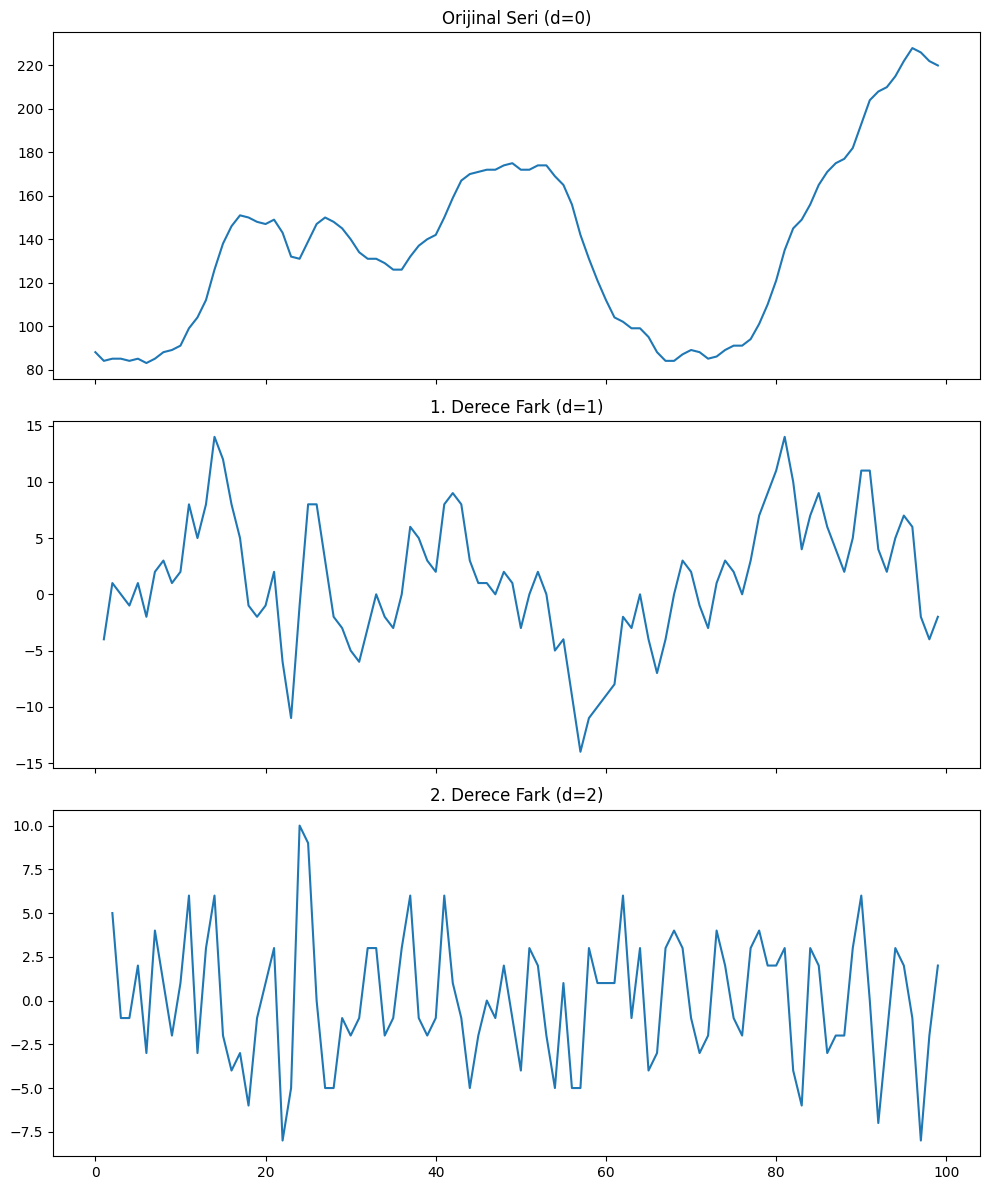


Önerilen d = 2 (Seri ancak 2. farkta durağanlaştı)


In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Fark derecelerini ve serileri hazırlayalım
y_diff1 = y.diff().dropna()
y_diff2 = y_diff1.diff().dropna()

# ADF testlerini gerçekleştirelim
def check_stationarity(series, label):
    result = adfuller(series)
    print(f'--- {label} ---')
    print(f'ADF İstatistiği: {result[0]:.4f}')
    print(f'p-değeri: {result[1]:.4e}') # Bilimsel gösterim çok küçük değerler için daha net
    return result[1]

# Grafikleri çizelim
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# 1. Orijinal Seri (d=0)
axes[0].plot(y); axes[0].set_title('Orijinal Seri (d=0)')
check_stationarity(y, "Orijinal (d=0)")

# 2. Birinci Fark (d=1)
axes[1].plot(y_diff1); axes[1].set_title('1. Derece Fark (d=1)')
p1 = check_stationarity(y_diff1, "1. Fark (d=1)")

# 3. İkinci Fark (d=2)
axes[2].plot(y_diff2); axes[2].set_title('2. Derece Fark (d=2)')
p2 = check_stationarity(y_diff2, "2. Fark (d=2)")

plt.tight_layout()
plt.show()

# Minimum d'yi belirleme
if p1 < 0.05:
    print("\nÖnerilen d = 1 (Seri 1. farkta durağanlaştı)")
elif p2 < 0.05:
    print("\nÖnerilen d = 2 (Seri ancak 2. farkta durağanlaştı)")

Burada bir ve iki fark sırası arasında yakın bir durumumuz var. Zaman serilerini fazla farklaştırmak ARIMA modellerinizin performansını da düşürebilir. Daha yakından bakalım:

👉 1. ve 2. fark sırası için otokorelasyon grafiğini ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) çizin.

(💡Profesyonel ipucu: Her statsmodels grafiği örneklemesinin sonuna `;` ekleyerek veya `plt.show()` çağırarak statsmodels grafiklerinin çoğaltılmasından kaçının)

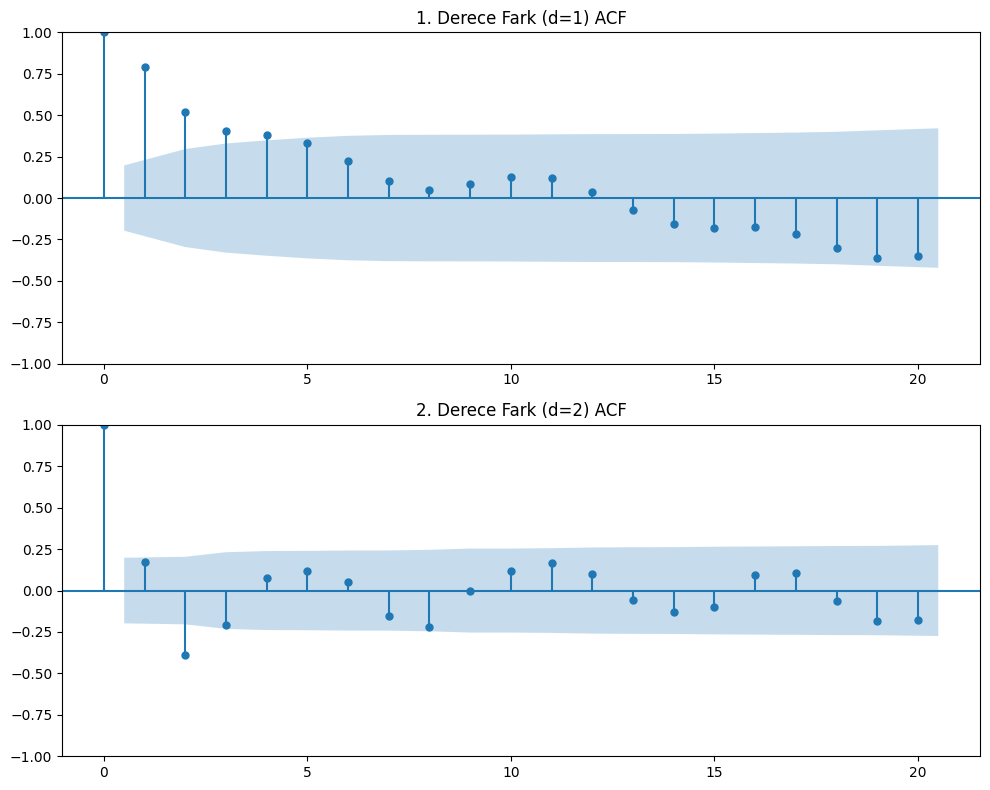

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

# Figür ve eksenleri hazırlayalım
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# 1. Derece Fark için ACF (d=1)
# Orijinal serinin farkını alıp boş değerleri atıyoruz
plot_acf(y.diff().dropna(), ax=axes[0], title="1. Derece Fark (d=1) ACF")

# 2. Derece Fark için ACF (d=2)
plot_acf(y.diff().diff().dropna(), ax=axes[1], title="2. Derece Fark (d=2) ACF")

plt.tight_layout()
plt.show()

"İkinci sıra fark" otokorelasyon grafiğimizde, 1 numaralı gecikme katsayısı 0'a yakın, ikincisi ise negatif bölgeye kadar uzanıyor. Bu, seriyi aşırı farklaştırdığımızı gösterebilir. (Unutmayın: her zaman 1'e eşit olan 0 numaralı gecikmeyİ hiçbir zaman umursamayız)

👉 (Geçici olarak) yalnızca bir fark sırasını tutalım ve bu seriyi `y_diff` olarak adlandıralım (daha sonra her zaman daha fazla fark deneyebiliriz)

In [6]:
y_diff = y.diff().dropna()

Az önce ARIMA'daki "I" terimini bulduk: durağan olmadan önce 1-fark için `d = 1` ("I", "entegrasyon"u ifade eder, "d" farklaştırma için...)

### Adım 2 - AR sırası (p) ve MA sırasını (q) seçin

#### MA($\color{blue}{q}$) = $Y^{\color{green}{(d)}}$'nin $\color{blue}{ACF}$'inin kesildiği gecikme sayısı

MA sırası (`q`), `y_diff`'e uygulanan otokorelasyon grafiğine ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bakılarak bulunabilir.

👉 `q`'yu belirleyin

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

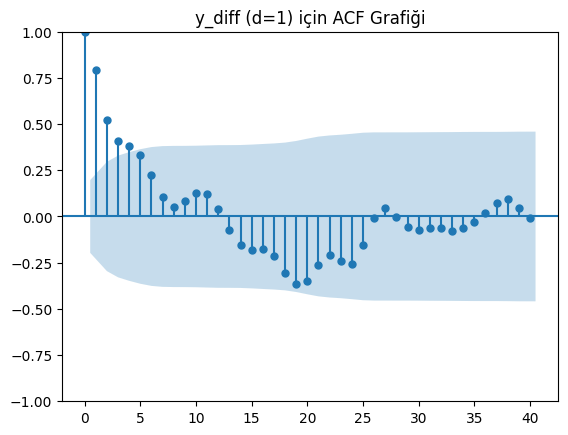

In [8]:
import matplotlib.pyplot as plt

# y_diff serisi üzerinde ACF grafiğini çizelim
# lags=40 verideki uzun dönemli korelasyonu görmek için yeterlidir
plot_acf(y_diff, lags=40)
plt.title("y_diff (d=1) için ACF Grafiği")
plt.show()

Modelimizi uydurma için değerlendirmemiz gereken maksimum değer q = 4 gibi görünüyor. Ancak, Otomatik-ARIMA kullanacak olsaydık (bu konuda daha sonra ayrıntılı bilgi), q=2 kullanmanın ideal sonuçlar verdiğini görürdük, bu nedenle başlangıçta q=2 ayarlamayı deneyelim.

Şüpheniz olduğunda, Y'yi yeterince açıklayan daha basit modeli seçin.

#### AR($\color{red}{p}$) = $Y^{\color{green}{(d)}}$'nin $\color{red}{PACF}$'inin kesildiği gecikme sayısı

AR sırası (`p`), `y_diff`'e uygulanan **k**ısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) incelenerek bulunabilir.

(Kısmi otokorelasyon, ara gecikmelerin katkılarını hariç tuttuktan sonra seri ile gecikmesi arasındaki korelasyon olarak düşünülebilir. Yani, PACF bir şekilde bir gecikme ile seri arasındaki saf korelasyonu iletir)

👉 `p`'yi belirleyin

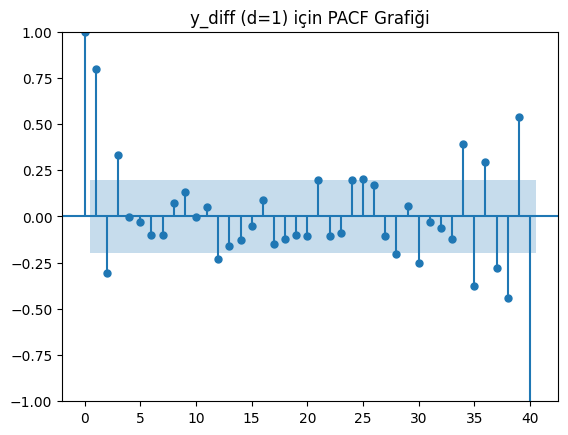

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# 'yule_walker' yerine 'yw' veya 'burg' kullanabiliriz
plot_pacf(y_diff, lags=40, method='yw')
plt.title("y_diff (d=1) için PACF Grafiği")
plt.show()

İlk 3 gecikme terimi anlamlılık düzeyinin üstünde göründüğü için `p = 3` seçebiliriz, ancak daha basit bir model `p = 1` ile de gidebiliriz.

### Adım 3 - Modeli oluşturun

Artık ARIMA için `p`, `d` ve `q` değerlerini seçtiğinize göre,

👉 `statsmodels`'den `arima_model`'i oluşturun.
- modeli uydurur
- modeli yazdır (`.summary`)

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# 1. Modeli Tanımlama
# Not: ARIMA fonksiyonuna orijinal 'y' serisini veriyoruz, 
# 'd=1' parametresi fark alma işlemini model içinde otomatik yapar.
model = ARIMA(y, order=(1, 1, 2))

# 2. Modeli Uydurma (Fit)
model_fit = model.fit()

# 3. Özet Raporunu Yazdırma
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Tue, 20 Jan 2026   AIC                            516.253
Time:                        19:40:39   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

☝️ P-değerleriniz çok yüksekse, karşılık gelen AR veya SA katsayılarını azaltarak bu terimleri kaldırmayı deneyin.

[`AIC - Akaike Bilgi Kriteri`](https://medium.com/towardsdatascience/the-akaike-information-criterion-c20c8fd832f2) değerini en aza indirerek uyumunuzun genel performansını değerlendirebilirsiniz

(1,1,1) ARIMA modellerinin aşırı uydurmaya karşı daha az şansı olduğu (p-değerleri düşük kalır) ve diğer modellerden neredeyse benzer bir AIC puanı koruduğu görülüyor

## 3. Model performansını değerlendirin

👉 `plot_predict()` yöntemi ile model tahminlerinizi görselleştirin

- Yöntemin varsayılan parametrelerine, özellikle `dynamic` parametrelerine yakından bakın.
- Modelinizin gerçekte böyle iyi bir performansa sahip olacağını düşünüyor musunuz?

In [15]:
from statsmodels.graphics.tsaplots import plot_predict

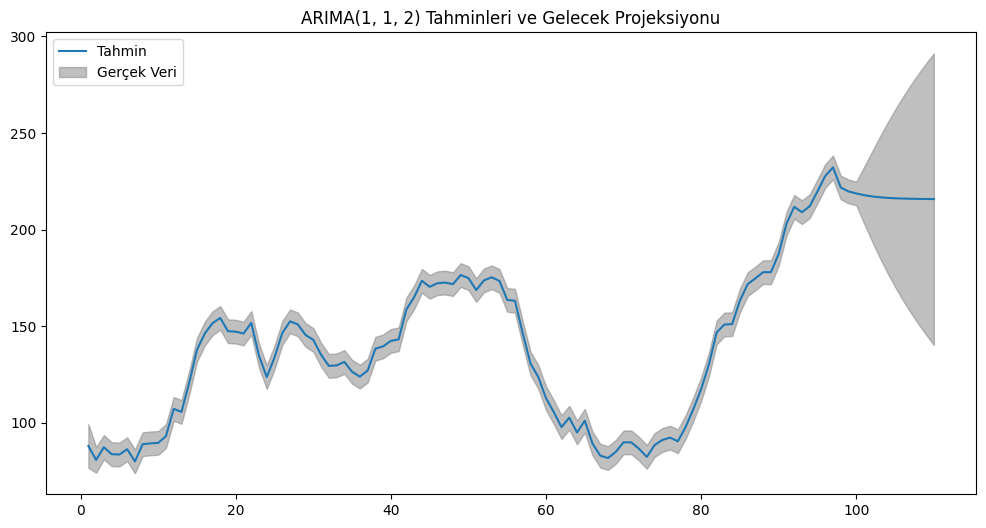

In [16]:
# Tahminleri görselleştirelim
fig, ax = plt.subplots(figsize=(12, 6))

# Orijinal veriyi ve modelin tahminlerini çiziyoruz
# start=1'den başlayarak mevcut 100 veriyi ve gelecek 10 adımı (end=110) kapsayalım
plot_predict(model_fit, start=1, end=110, ax=ax)

plt.title("ARIMA(1, 1, 2) Tahminleri ve Gelecek Projeksiyonu")
plt.legend(['Tahmin', 'Gerçek Veri', 'Güven Aralığı'], loc='upper left')
plt.show()

☝️ `dynamic=False`, `y_pred`'i tahmin etmek için mevcut tüm `y` değerlerini kullanır, bu da ARIMA tahminizin $y_t$'yi tahmin etmek için $y_{t-1}$'e kadar kullanmasını sağlar. Gerçekte, özellikle gelecekte birkaç aralığı tahmin etmek istiyorsanız tüm `y`'ye erişiminiz yoktur.

👉 Modelin yalnızca _85'e kadar verilere erişimi_ olan bir durumda _son 15 değeri_ tahmin eden bir tahmini çizmek için `dynamic=True` kullanmayı deneyin. Yani model:
- gerçek [1...85]'e dayalı olarak 86'yı tahmin eder
- sonra 86 için önceden tahmin ettiği değer _artı_ [1...85]'e dayalı olarak 87'yi tahmin eder
- vb...100'e kadar yinelemeli olarak

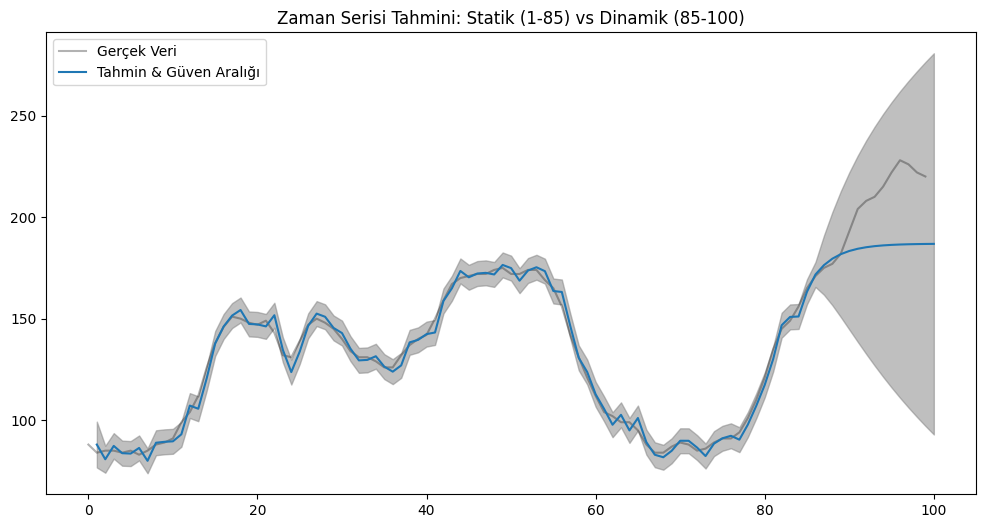

In [17]:
# Grafiği hazırlayalım
fig, ax = plt.subplots(figsize=(12, 6))

# Orijinal veriyi çizelim
ax.plot(y, label='Gerçek Veri', color='black', alpha=0.3)

# Tahmini 85. indeksten itibaren dinamik olarak başlatalım
# dynamic=85 demek: 85'e kadar gerçek veriyi kullan, sonrasında kendi tahminlerine geç demektir.
plot_predict(model_fit, start=1, end=100, dynamic=85, ax=ax)

plt.title("Zaman Serisi Tahmini: Statik (1-85) vs Dinamik (85-100)")
plt.legend(['Gerçek Veri', 'Tahmin & Güven Aralığı'], loc='upper left')
plt.show()

☝️ Bu hala _gerçek_ bir tahmin değil! Neden?

<details>
    <summary>Cevap</summary>

Modelimiz uyum aşamasında tüm `y_true` serisini "gördü"!
</details>

### 3.1 Örneklem Dışı Tahminler (gerçek "gelecek")

👉 Test seti için yalnızca son 15 veri noktasını tutarak bir eğitim-test bölümü oluşturun ve ARIMA'nızı yalnızca eğitim setinde eğitin.

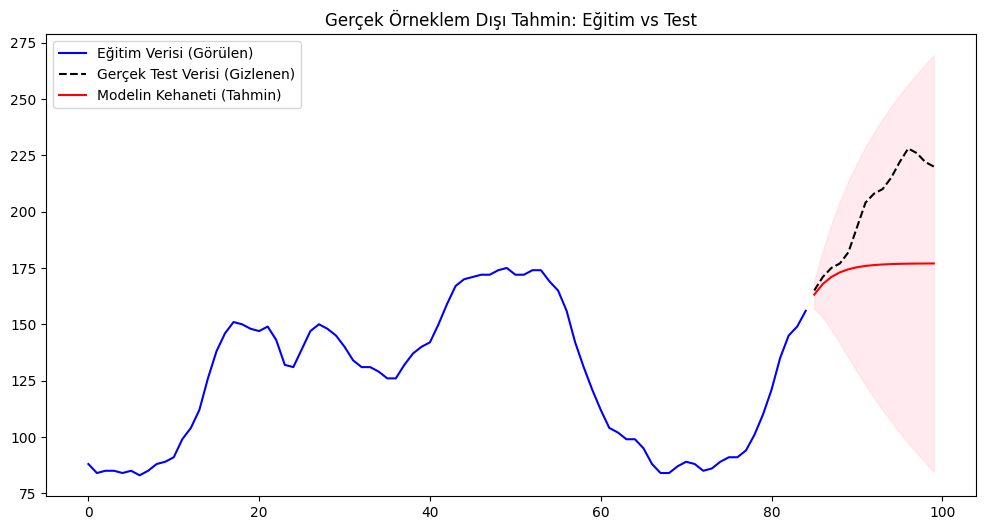

In [18]:
# 1. Veriyi Bölme (Son 15 veri noktasını test için ayıralım)
train = y[:85]
test = y[85:]

# 2. Modeli SADECE Eğitim Setiyle Kurma ve Eğitme
# ARIMA(1, 1, 1) parametrelerini kullanıyoruz (daha stabil sonuçlar için)
model_train = ARIMA(train, order=(1, 1, 1))
model_train_fit = model_train.fit()

# 3. Örneklem Dışı Tahmin (Out-of-sample Forecast)
# 15 adım sonrasını (test setinin uzunluğu kadar) tahmin ediyoruz
forecast_result = model_train_fit.get_forecast(steps=15)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 4. Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train, label='Eğitim Verisi (Görülen)', color='blue')
plt.plot(test, label='Gerçek Test Verisi (Gizlenen)', color='black', linestyle='--')
plt.plot(forecast, label='Modelin Kehaneti (Tahmin)', color='red')

# Güven aralığını dolduralım
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title("Gerçek Örneklem Dışı Tahmin: Eğitim vs Test")
plt.legend()
plt.show()

👉 Şimdi 85. adımdayız ve geleceği hiç görmedik:
- Sonraki 15 veri noktasını (yani eğitim veri setinizin sonundan sonrasını) "tahmin etmek" için uydurduğunuz `arima` modelinde `get_forecast()` yöntemini kullanın

Yöntem `statsmodels`'den bir `PredictionResultsWrapper` nesnesi döndürür.

**💻 Bu sonucu `forecast_results` adlı bir değişkende saklayın.**

İlk başta gezinmek zordur, ancak işte bazı ipuçları:
- Tahminlerinizi `forecast_results.predicted_mean`'de bulabilirsiniz
- Güven aralıklarınız `forecast_results.conf_int()` tarafından verilir

In [19]:
# 1. Modeli sadece ilk 85 veri (train) ile eğitelim
# (Veri sızıntısını önlemek için bu adım kritiktir)
model_train = ARIMA(train, order=(1, 1, 1))
model_train_fit = model_train.fit()

# 2. Geleceği tahmin etme (Out-of-sample forecast)
# 💻 Sonucu forecast_results değişkeninde saklıyoruz
forecast_results = model_train_fit.get_forecast(steps=15)

# 3. Sonuçları ayrıştıralım
forecast = forecast_results.predicted_mean      # Nokta tahminleri
confidence_intervals = forecast_results.conf_int() # Alt ve üst sınırlar

👉 Tahmin edilen değerleri ve ayrıca %95 belirsizlik aralığının üst ve alt aralığını çizin

👉 Model performansını geçmişe göre daha iyi kavramak için önceki 85 `y` gerçek veri noktanızı da çizmeyi deneyin

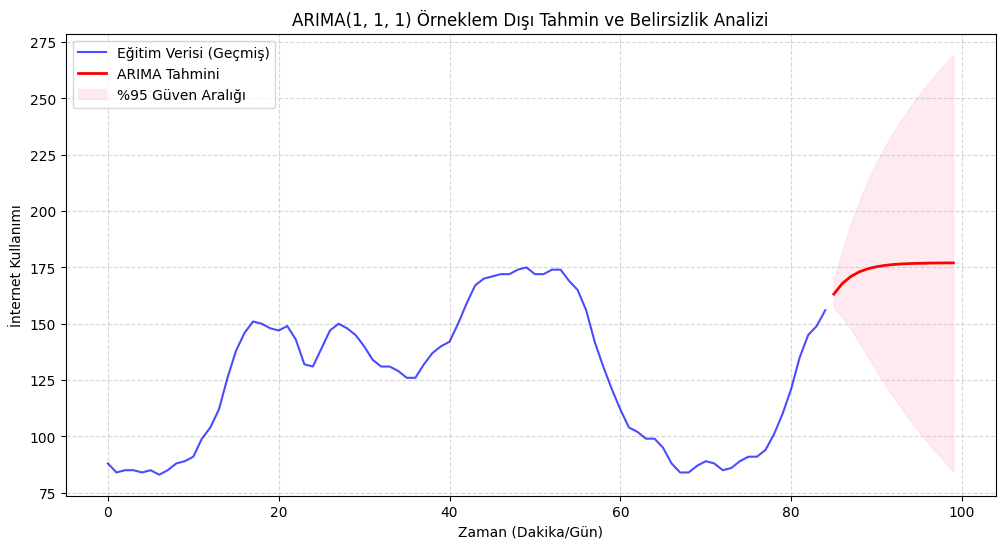

In [21]:
# 1. Figür boyutunu ayarlayalım
plt.figure(figsize=(12, 6))

# 2. Geçmiş Veriler (0-85 arası gerçek değerler)
plt.plot(train.index, train, label='Eğitim Verisi (Geçmiş)', color='blue', alpha=0.7)

# 3. Model Tahmini (85-100 arası kırmızı çizgi)
plt.plot(forecast.index, forecast, label='ARIMA Tahmini', color='red', linewidth=2)

# 4. %95 Güven Aralığı (Belirsizlik Aralığı)
# conf_int() fonksiyonundan gelen alt ve üst sınırları kullanıyoruz
plt.fill_between(forecast.index, 
                 confidence_intervals.iloc[:, 0], # Alt sınır
                 confidence_intervals.iloc[:, 1], # Üst sınır
                 color='pink', alpha=0.3, label='%95 Güven Aralığı')

# 5. Gerçekleşen Test Verisi (Kıyaslama için isteğe bağlı)
# plt.plot(test.index, test, label='Gerçekleşen (Test)', color='black', linestyle='--')

# Grafik Detayları
plt.title("ARIMA(1, 1, 1) Örneklem Dışı Tahmin ve Belirsizlik Analizi")
plt.xlabel("Zaman (Dakika/Gün)")
plt.ylabel("İnternet Kullanımı")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### 3.2 %95 güven aralığınıza güvenebilir misiniz? (çıkarım koşulları)

👉 Hiçbir örüntü olmadığından emin olmak için artıkları `model.resid` çizin
- Normal dağılım
- Sıfır ortalama
- Tekdüze varyans
- Oto-regresif örüntü yok (isterseniz artıkları plot_acf yapabilirsiniz)

Not: artıklar `plot_predict(dynamic=False)`'daki gibi tüm verileri 'görerek' oluşturulur

Ayrıca, artıkların yaklaşık olarak normal dağılımda olup olmadığını görmek için artıkların bir histogramını veya KDE uyumunu çizmeyi deneyin.

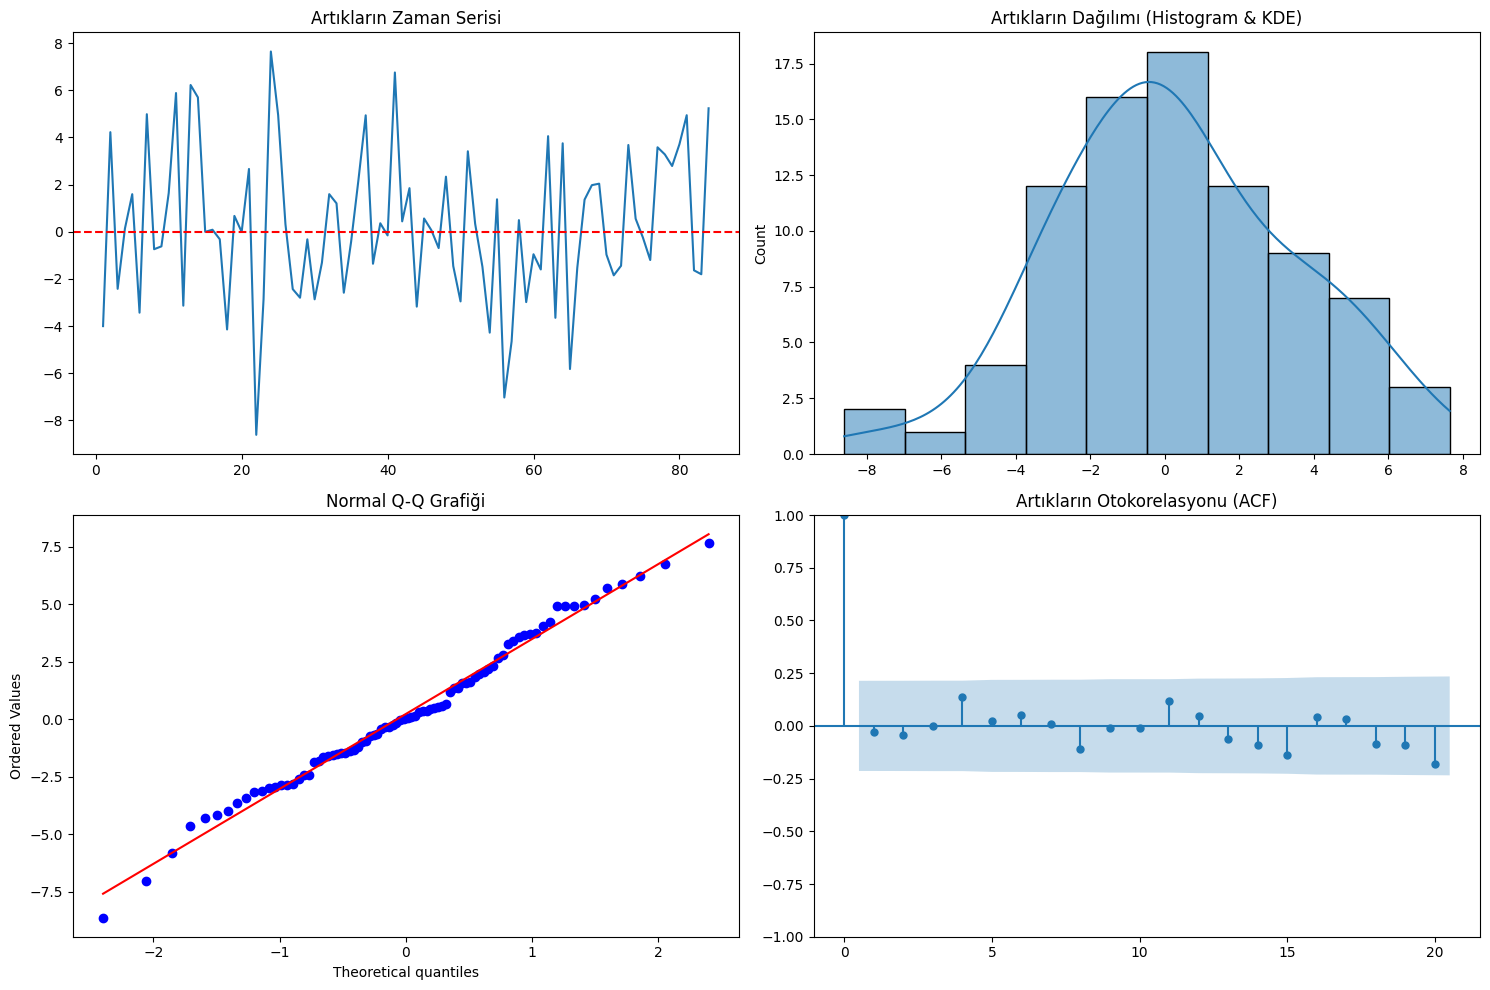

In [22]:
# 1. Artıkları alalım (Eğitim seti üzerindeki hatalar)
residuals = model_train_fit.resid[1:] # İlk değer fark alma nedeniyle 0 veya NaN olabilir

# 2. Teşhis Paneli Oluşturalım
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# --- Grafik 1: Artıkların Zaman Serisi (Sıfır Ortalama ve Sabit Varyans) ---
ax1.plot(residuals)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title('Artıkların Zaman Serisi')

# --- Grafik 2: Histogram ve KDE (Normal Dağılım Kontrolü) ---
import seaborn as sns
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_title('Artıkların Dağılımı (Histogram & KDE)')

# --- Grafik 3: Q-Q Plot (Normal Dağılım İçin Daha Hassas Test) ---
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Normal Q-Q Grafiği')

# --- Grafik 4: Artıkların ACF Grafiği (Otokorelasyon Kontrolü) ---
plot_acf(residuals, ax=ax4)
ax4.set_title('Artıkların Otokorelasyonu (ACF)')

plt.tight_layout()
plt.show()

## 3.3 Çapraz doğrulanmış performans ölçümleri

👉 Aşağıda zaman serileri için en yaygın performans ölçümleri yer almaktadır

In [23]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

👉 ARIMA hiper-parametrelerinizle oynayın ve tahmin performansınız üzerindeki etkisini görün

In [24]:
# Fonksiyonu kullanarak metrikleri hesaplayalım
# forecast: model_train_fit.get_forecast(15).predicted_mean
# test: y[85:]
accuracy_metrics = forecast_accuracy(forecast, test)

# Sonuçları daha okunaklı yazdıralım
print("--- ARIMA(1, 1, 1) Performans Ölçümleri ---")
for metric, value in accuracy_metrics.items():
    print(f"{metric.upper():<8}: {value:.4f}")

--- ARIMA(1, 1, 1) Performans Ölçümleri ---
MAPE    : 0.1252
ME      : -26.8715
MAE     : 26.8715
MPE     : -0.1252
RMSE    : 32.3824
ACF1    : 0.8714
CORR    : 0.8529
MINMAX  : 0.1252


## 4 Izgara Arama

`pmdarima` kullanarak (p,d,q) için bir Izgara Arama çalıştırmayı deneyin. En azından şunları kullanın:
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [28]:
import pmdarima as pm

y_train = train

model = pm.auto_arima(
    y_train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.01 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.01 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.161 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Tue, 20 Jan 2026   AIC                   

/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-pack

## (İsteğe bağlı) Modelinizin Performansını Çapraz Doğrulayın

Pratikte, sonuçlar ve Izgara Arama her zaman çapraz doğrulanmalıdır:

Modelinizin performansını gerçekten değerlendirmek ve çapraz doğrulamadan sonra en iyi hiperparametreleri bulmak için bitişik K-katlar oluşturmak amacıyla [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) kullanmaktan çekinmeyin.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - TimeSeriesSplit + Izgara Arama kullanarak Çapraz Doğrulama**

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# 1. Cross-Validation ayarlarını yapalım (Örn: 5 katmanlı split)
tscv = TimeSeriesSplit(n_splits=5)
mape_scores = []

# 2. Döngü içinde her split için modeli eğitelim
# 'y' tüm seriyi (100 veri) temsil eder
for train_index, test_index in tscv.split(y):
    # Eğitim ve Test setlerini ayıralım
    cv_train, cv_test = y.iloc[train_index], y.iloc[test_index]
    
    # Modeli her split'te eğit (ARIMA(1, 1, 1) üzerinden örnekliyoruz)
    try:
        model_cv = ARIMA(cv_train, order=(1, 1, 1)).fit()
        
        # Test setinin uzunluğu kadar tahmin yap
        forecast_cv = model_cv.get_forecast(steps=len(cv_test)).predicted_mean
        
        # MAPE hesapla (Daha önce tanımladığımız fonksiyonu veya manuel hesaplamayı kullanabiliriz)
        mape = np.mean(np.abs(forecast_cv - cv_test) / np.abs(cv_test))
        mape_scores.append(mape)
        
        print(f"Fold {len(mape_scores)}: MAPE = {mape:.4f}")
    except:
        continue

# 3. Ortalama performansı yazdıralım
print(f"\n--- Ortalama Cross-Validation MAPE: {np.mean(mape_scores):.4f} ---")

Fold 1: MAPE = 0.0536
Fold 2: MAPE = 0.2133
Fold 3: MAPE = 0.4820
Fold 4: MAPE = 0.1968
Fold 5: MAPE = 0.2155

--- Ortalama Cross-Validation MAPE: 0.2322 ---


In [32]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

results_list = []

# Denemek istediğiniz parametre aralıkları
p_params = range(0, 3)
d_params = range(0, 2)
q_params = range(0, 3)

for p in p_params:
    for d in d_params:
        for q in q_params:
            try:
                # Modeli kur ve eğit
                model = ARIMA(train, order=(p, d, q)).fit()
                
                # AIC ve diğer metrikleri listeye ekle
                results_list.append({
                    'p': p,
                    'd': d,
                    'q': q,
                    'order': (p, d, q),
                    'AIC': model.aic
                })
            except:
                continue

# Listeyi DataFrame'e dönüştür
df_results = pd.DataFrame(results_list)

# Şimdi sıralama işlemini yapabilirsiniz
best_models = df_results.sort_values('AIC').reset_index(drop=True)
print(best_models.head())

/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


   p  d  q      order         AIC
0  1  1  1  (1, 1, 1)  440.109413
1  1  1  2  (1, 1, 2)  441.939017
2  2  1  1  (2, 1, 1)  442.051527
3  2  1  2  (2, 1, 2)  443.516369
4  2  1  0  (2, 1, 0)  444.907047


/home/egkpnr/.pyenv/versions/workintech_current/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


☝️ İlk model seçimimiz (1, 1, 2) çok da kötü değil!
Veri seti (100 veri noktası) gerçekte herhangi bir şeyi çapraz doğrulamak için çok küçük olduğuna dikkat edin!

In [34]:
# Eğer birden fazla deneme varsa ortalama AIC değerine göre sırala
summary = df_results.groupby('order')['AIC'].mean().sort_values()
print(summary)

order
(1, 1, 1)    440.109413
(1, 1, 2)    441.939017
(2, 1, 1)    442.051527
(2, 1, 2)    443.516369
(2, 1, 0)    444.907047
(0, 1, 2)    445.677354
(2, 0, 2)    449.178171
(1, 1, 0)    449.461880
(2, 0, 1)    449.641540
(2, 0, 0)    456.235816
(1, 0, 2)    457.850738
(0, 1, 1)    468.806809
(1, 0, 1)    481.726618
(0, 1, 0)    534.088309
(1, 0, 0)    547.248137
(0, 0, 2)    628.843512
(0, 0, 1)    718.970531
(0, 0, 0)    826.196577
Name: AIC, dtype: float64
